# NB1 Evaluation of retrospective streamflow simulation at naturalized flow sites

In [2]:
%matplotlib inline  
import os, sys
import glob
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import scale as mscale
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

from scripts.units import cms2csf
from scripts.utility import AutoVivification
from scripts.utility import PPFScale
mscale.register_scale(PPFScale)
import scripts.metrics as metrics
import scripts.colors as color
from scripts.utility import base_map

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


In [3]:
def reorder_dataset(ds, siteID):
    # extract the reachID orders
    x = ds['site'].values
    # Find the indices of the reordered array
    # From: https://stackoverflow.com/questions/8251541/numpy-for-every-element-in-one-array-find-the-index-in-another-array
    index = np.argsort(x)
    sorted_x = x[index]
    sorted_index = np.searchsorted(sorted_x, siteID)

    remap_order = np.take(index, sorted_index, mode="clip")

    # Reorder pio according to the orginal
    return ds.isel(dict(site=remap_order))

## 1. Setup

In [ ]:
# directories
main_path  = '/glade/campaign/ral/hap/mizukami/archive/pnw_hydrology/final_archive_v1' # !!! This is top directory of the dataset.
geo_path   = os.path.join(main_path, 'ancillary_data','geospatial_data')
nrni_path  = os.path.join(main_path, 'ancillary_data')
figure_path = 'NB1_figures'
os.makedirs(figure_path, exist_ok=True)
os.makedirs(os.path.join(figure_path, 'per_site'), exist_ok=True)

In [5]:
# for time series
cal_period = slice('1991-10-01', '2001-09-30')
val_period = slice('2001-10-01', '2010-09-30')

# for skill metrics computation
analysis_period = val_period #slice('1971-10-01', '2010-09-30')

ds_sim = {}
case_meta = {
    'GMET': {'label':'SUMMA-mizuRoute', 'color':'red'},
}

sim_case = list(case_meta.keys())
all_case = sim_case+['obs']

## 2.Load data 

### 2.1 geospatial data

#### 2.1.1 SUMMA HRU (gpkg)

In [7]:
df_huc12 = gpd.read_file(os.path.join(geo_path, 'HUC12_MERIT_PNW.gpkg'))
df_huc12['geometry'] = df_huc12.geometry.simplify(0.01) # simplified

#### 2.1.2 Naturalized flow site (gpkg)

In [26]:
df_site = gpd.read_file(os.path.join(geo_path, 'PNW_flow_site.gpkg'))

### 2.2 Link between river network reach ID and site name
reach id co-located with flow site has less probably because some reach has more than one sites 

In [13]:
df_merit_id = pd.read_csv(os.path.join(geo_path, 'PNW_flow_site.csv'))
df_merit_id.head()

,index,location_name,location_latitude,location_longitude,location_description,flowDataExist,river,calib_indiv,calib_geo_region,route_id,bmorph,USGS_ID,area_sqkm
0,0,LUC,43.527669,-116.059554,Boise River Lucky Peak Inflow,1,tributary,0,0,78024299,1,13202000,6941.17320
1,1,COT,43.720800,-123.048600,Cottage Grove,1,tributary,1,1,78024815,1,14153500,269.35896
2,2,KER,47.680300,-114.245800,Kerr,1,tributary,0,0,78015546,1,12372000,18352.66914
3,3,RIM,46.662618,-121.124802,RIMROCK RESERVOIR - TIETON RIVER,1,tributary,1,1,78018163,1,12491500,484.32813
4,4,FLTI,43.458361,-110.797028,"Flat Creek DS of cache cr nr Moose, WY",0,tributary,0,0,78024759,0,NaN,NaN


### 2.3 Naturalized flow data

In [9]:
ds_nrni = xr.open_dataset(os.path.join(nrni_path,'PNW_unimpaired_flow_1951-2018_latlon.nc'))
nrni_site = ds_nrni.site.values
print('Number of nrni sites: %d'%len(nrni_site))

Number of nrni sites: 231


### 2.4 Read retrospective SUMMA simulations

In [21]:
%%time
ds_summa = {}
for case,_ in case_meta.items():
    nclist=glob.glob(os.path.join(main_path, f'{case}_hist', 'mizuRoute_daily_site.nc'))
    ds_summa[case] = xr.open_mfdataset(nclist).load()
    ds_summa[case] = ds_summa[case].assign_coords(seg=ds_summa[case]['site'])
    ds_summa[case] = ds_summa[case].drop_vars('site')
    ds_summa[case] = ds_summa[case].rename({'seg':'site'})
flow_site = ds_summa[case].site.values
print('Number of SUMMA sites: %d'%len(ds_summa[case].reachID))

Number of SUMMA sites: 414
CPU times: user 15.9 ms, sys: 12 ms, total: 27.8 ms
Wall time: 130 ms


## 3. Reformat xarray dataset to panda dataframe
Find site where naturalized flow exist (summa site has all the sites in the meta data)

In [22]:
# Find common site between summa site (include all the sites) and nrni_site (site from naturalized flow data)
common_site = np.asarray(list(set(flow_site).intersection(nrni_site)))
num_site = len(common_site)
common_site

array(['PARI', 'MEHO', 'MORW', 'CHEI', 'IHR', 'YAQO', 'COR', 'PRVO',
       'SPEW', 'ARK', 'FOS', 'SSUW', 'PARW', 'ISSW', 'BENO', 'ALB',
       'NEWW', 'NISW', 'HCR', 'RAWW', 'RML', 'TRAO', 'AND', 'DEBO',
       'VIDO', 'LAPO', 'DOR', 'SLM', 'PSL', 'LIB', 'CGMW', 'WOODGOOD',
       'HFAI', 'KAC', 'JASO', 'BOX', 'HAH', 'PLEI', 'CGR', 'JCK', 'CLFW',
       'SVN', 'HCD', 'BCDW', 'OXB', 'LIM', 'ALF', 'FAL', 'WICO', 'LMN',
       'CHL', 'ROS', 'CFM', 'MON', 'NIN', 'KALAR', 'MPLO', 'SQUW', 'YUMW',
       'CLE', 'TLMO', 'THNW', 'ARD', 'BLU', 'SWF', 'SHYI', 'AUGW', 'HRFW',
       'DKBW', 'MROW', 'PAYI', 'SKHI', 'GEEW', 'DED', 'PABI', 'DWR',
       'RIS', 'LLK', 'PRLI', 'LOS', 'EKTO', 'CROO', 'NSSW', 'BRI', 'GPR',
       'AMRW', 'KIOW', 'ELWW', 'BFTI', 'GCL', 'NOX', 'UMTW', 'BFE',
       'CRPW', 'MNRO', 'ELEW', 'MFNW', 'SUV', 'CSC', 'RIR', 'ANA', 'LGS',
       'CULO', 'MAY', 'CS1', 'WAT', 'WHYCHUS', 'WFWI', 'NKSW', 'BDY',
       'MMD', 'KIMI', 'ORO', 'FSSO', 'JKSY', 'PRD', 'SPD', 'LOP', 'TRY',


### select common sites only 

In [27]:
# flow site meta dataframe
df_site_selected = df_site.loc[df_site['location_name'].isin(common_site)]

In [28]:
# select common sites from NRNI data
ds_nrni_selected = ds_nrni.where(ds_nrni.site.isin(common_site), drop=True)

In [30]:
# select common sites from VIC data
ds_sim_selected = {}
for case in sim_case:
    ds_sim_selected[case] = ds_sim[case].where(ds_sim[case].site.isin(common_site), drop=True)
    # March order of site with order of NRNI data
    ds_sim_selected[case] = reorder_dataset(ds_sim_selected[case], ds_nrni_selected.site.values)

## 4. Performance metrics for all the common sites - SUMMA vs unimpaird flow

In [31]:
# Compute skill metrics based on daily data (VIC vs NRNI and SUMMA vs NRNI)
prob=np.arange(1,float(len(ds_nrni_selected['time'].sel(time=analysis_period))+1))/(1+len(ds_nrni_selected['time'].sel(time=analysis_period))) #probability
for d in range(len(prob)):
    idx50=d
    if prob[d] > 0.5: break
for d in range(len(prob)):
    idx10=d
    if prob[d] > 0.1: break
for d in range(len(prob)):
    idx90=d
    if prob[d] > 0.9: break
for d in range(len(prob)):
    idx98=d
    if prob[d] > 0.98: break

alpha_array = np.zeros((num_site, len(sim_case)))
beta_array  = np.zeros((num_site, len(sim_case)))
corr_array  = np.zeros((num_site, len(sim_case)))
kge_array   = np.zeros((num_site, len(sim_case)))
pbiasFHV90_array = np.zeros((num_site, len(sim_case)))
pbiasFHV98_array = np.zeros((num_site, len(sim_case)))
pbiasFLV10_array = np.zeros((num_site, len(sim_case)))

for r, site in enumerate(common_site):
    for c, case in enumerate(sim_case): 
        sr_sim = ds_sim_selected[case].sel(time=analysis_period).sel(site=site)['streamflow'].values
        sr_sim = np.where(sr_sim<0.0, 1.0e-7,sr_sim)
        sr_sim_sort = np.sort(sr_sim)
        if c == 0:
            sr_obs = ds_nrni_selected.sel(time=analysis_period).sel(site=site)['streamflow'].values
            sr_obs = np.where(sr_obs<0.0, 1.0e-7,sr_obs)
            sr_obs_sort =  np.sort(sr_obs)
            #qthresh90 = np.percentile(sr_obs, 90)

        alpha_array[r,c] = metrics.alpha(sr_obs, sr_sim)
        beta_array[r,c]  = metrics.beta(sr_obs, sr_sim)
        corr_array[r,c]  = metrics.corr(sr_obs, sr_sim)
        kge_array[r,c]   = metrics.kge(sr_obs, sr_sim)
        #pbias90_array[r,c]    = metrics.pbias(sr_obs[sr_obs>qthresh90], sr_sim[sr_obs>qthresh90])*100
        pbiasFHV98_array[r,c] = metrics.pbias(sr_obs_sort[idx98:], sr_sim_sort[idx98:])*100
        pbiasFHV90_array[r,c] = metrics.pbias(sr_obs_sort[idx90:], sr_sim_sort[idx90:])*100
        pbiasFLV10_array[r,c] = metrics.pbias(sr_obs_sort[:idx10], sr_sim_sort[:idx10])*100

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/glade/u/apps/opt/co

### 4.1 CDF plots for flow performance statistics - all the flow sites

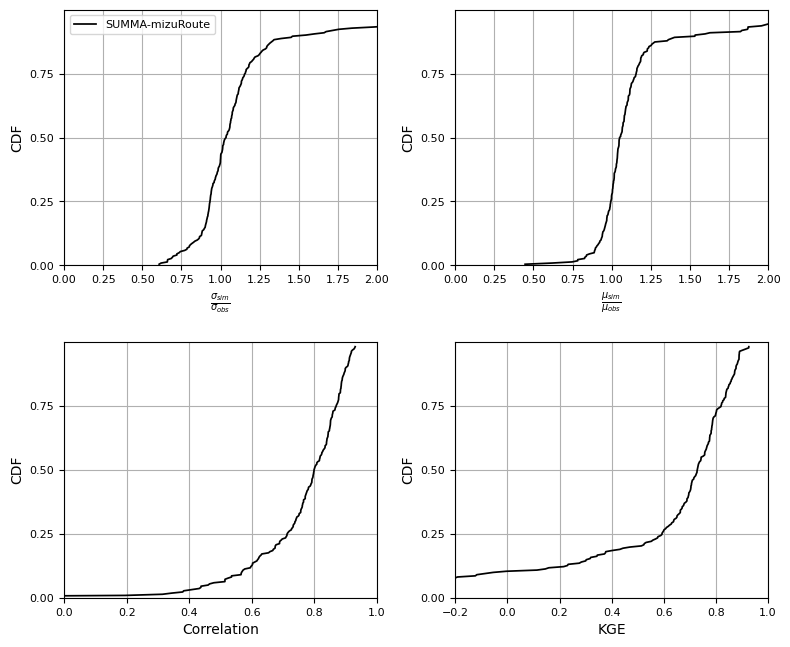

In [32]:
%matplotlib inline 
# 4 panel CDFs (alpha, beta, correlation and KGE)
fig = plt.figure(figsize=(8.0, 7.0))
fig.subplots_adjust(left=0.095,right=0.975,bottom=0.095,top=0.935,wspace=0.25,hspace=0.30)

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

ax1.tick_params(labelsize=8)
ax2.tick_params(labelsize=8)
ax3.tick_params(labelsize=8)
ax4.tick_params(labelsize=8)

clr=['k','r','b','m','c']
lstyle=['-','-','-','-','-']

plot_case = sim_case

#panel a) alpha
for c, case in enumerate(plot_case):
    idx = sim_case.index(case)
    xdata = alpha_array[:,idx]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax1.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=case_meta[case]['label'],linewidth=1.25)
lgd = ax1.legend(frameon=True,loc="best", handlelength=2, prop={'size':8})
lgd.get_frame().set_facecolor('white')
ax1.set_xlim(0.0, 2.0) #ratio
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.set_yticks(np.arange(0, 1, 0.25))
ax1.set_xlabel(r'$\frac{\sigma_{sim}}{\sigma_{obs}}$')
ax1.set_ylabel('CDF')

#panel b) beta
for c, case in enumerate(plot_case):
    idx = sim_case.index(case)
    xdata = beta_array[:,idx]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax2.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=case,linewidth=1.25)
ax2.set_xlim(0.0, 2.0) #ratio
ax2.set_ylim(0, 1)
ax2.grid(True)
ax2.set_yticks(np.arange(0, 1, 0.25))
ax2.set_xlabel(r'$\frac{\mu_{sim}}{\mu_{obs}}$')
ax2.set_ylabel('CDF')

#panel c) correlation
for c, case in enumerate(plot_case):
    idx = sim_case.index(case)
    xdata = corr_array[:,idx]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax3.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=case,linewidth=1.25)
ax3.set_xlim(0.0, 1.0) # corr
ax3.set_ylim(0, 1)
ax3.grid(True)
ax3.set_yticks(np.arange(0, 1, 0.25))
ax3.set_xlabel('Correlation')
ax3.set_ylabel('CDF')

#panel d) KGE
for c, case in enumerate(plot_case):
    idx = sim_case.index(case)
    xdata = kge_array[:,idx]
    xdata_sort = np.sort(xdata)
    prob_metric = np.arange(1,float(len(xdata)+1))/(1+len(xdata))
    maxval = 1.1*np.max(xdata)
    minval = 0.9*np.min(xdata)
    ax4.plot(xdata_sort,prob_metric,c=clr[c],ls=lstyle[c],label=case,linewidth=1.25)
ax4.set_xlim(-0.2, 1.0)
ax4.set_ylim(0, 1)
ax4.grid(True)
ax4.set_yticks(np.arange(0, 1, 0.25))
ax4.set_xlabel('KGE')
ax4.set_ylabel('CDF');

plt.savefig(os.path.join(figure_path, 'fig1_KGE_cdf.png'), dpi=300, bbox_extra_artists=(lgd,))

### 4.2 PDF plots for high/low flow metrics - all the flow sites

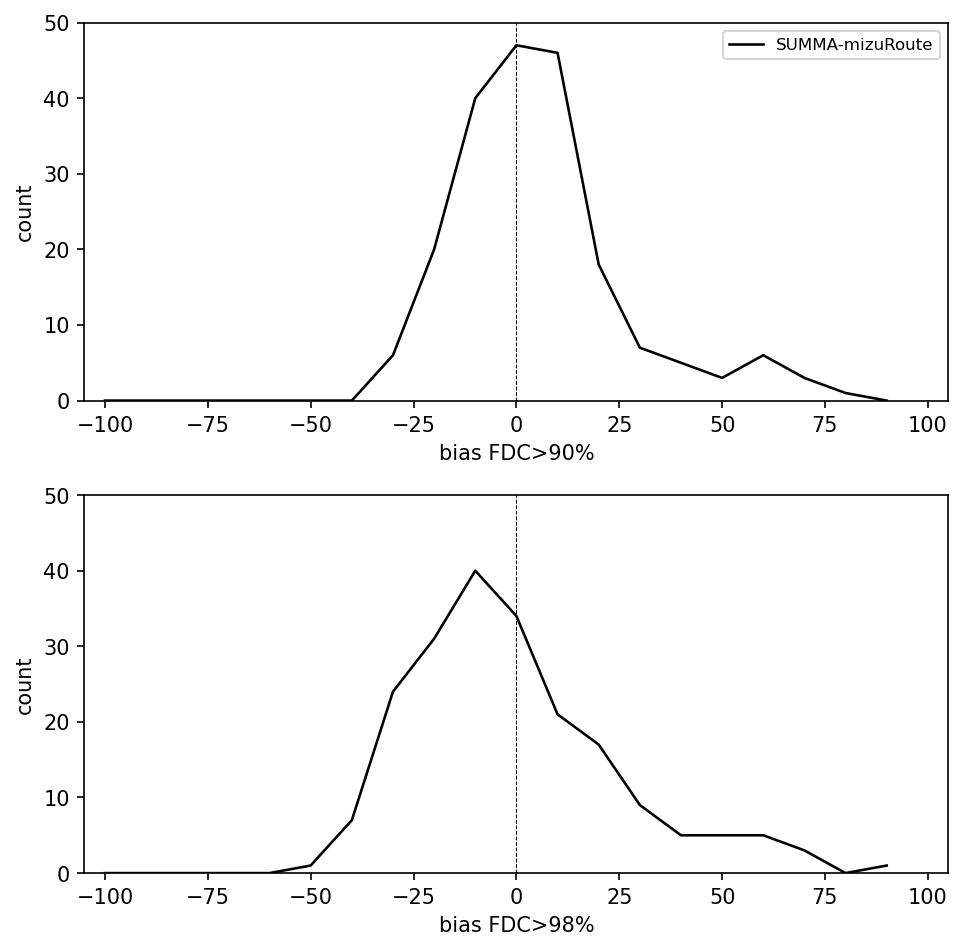

In [33]:
# PDF high flow bias
plot_case = sim_case
fig, ax = plt.subplots(2,1, figsize=(6.0, 6.0), dpi=150)
plt.subplots_adjust(left=0.015, bottom=0.015, right=0.975, top=0.96, hspace=0.25, wspace=0.1)

clr=['k','r','b','m','c']
lstyle=['-','-','-','-','-']

for c, case in enumerate(plot_case):
    idx = sim_case.index(case)
    y, x = np.histogram(pbiasFHV90_array[:,idx], bins = np.arange(-100, 110, 10), density=False)
    ax[0].plot(x[:-1], y, c=clr[c],ls=lstyle[c],label=case_meta[case]['label'],linewidth=1.25)
    
ax[0].axvline(x = 0, color = 'k', ls='--',lw=0.5, label = '')
lgd = ax[0].legend(frameon=True,loc="best", handlelength=2, prop={'size':8})
lgd.get_frame().set_facecolor('white')
ax[0].set_xlim(-105, 105) #ratio
ax[0].set_ylim(0, 50)
ax[0].set_xlabel(r'bias FDC>90%')
ax[0].set_ylabel('count');

for c, case in enumerate(plot_case):
    idx = sim_case.index(case)
    y, x = np.histogram(pbiasFHV98_array[:,idx], bins = np.arange(-100, 110, 10), density=False)
    ax[1].plot(x[:-1], y, c=clr[c],ls=lstyle[c],label=case_meta[case]['label'],linewidth=1.25)

ax[1].axvline(x = 0, color = 'k', ls='--',lw=0.5, label = '')
ax[1].set_xlim(-105, 105) #ratio
ax[1].set_ylim(0, 50)
ax[1].set_xlabel(r'bias FDC>98%')
ax[1].set_ylabel('count');

plt.savefig(os.path.join(figure_path, 'Fig2_FDC_bias_pdf.png'), bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

### 4.3. Mapping of flow skill statistics

#### 4.3.1 beta

count    218.000000
mean       1.244016
std        1.326965
min        0.446325
25%        0.993969
50%        1.048759
75%        1.149755
max       19.045532
Name: GMET, dtype: float64
19% or less bias at 75% of sites


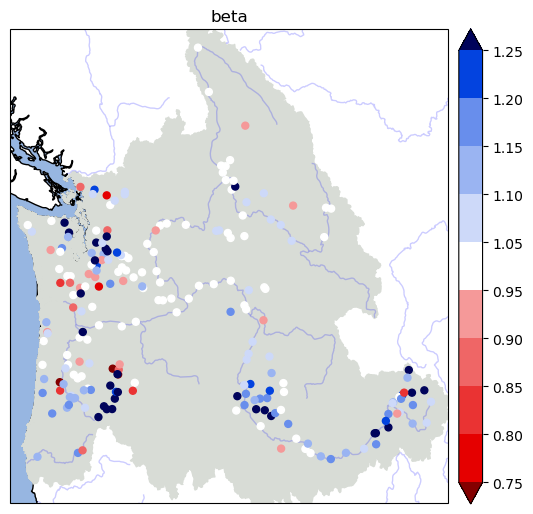

In [34]:
case = 'GMET' # e.g.,'GMET'

df_metric= pd.DataFrame(data=beta_array, index=common_site, columns=sim_case)
df_metric.reset_index(level=0, inplace=True)
df_metric.rename(columns={'index':'location_name'},inplace=True)
df_metric_final = df_site_selected.merge(df_metric, on="location_name", how = 'inner')

fig, ax1 = plt.subplots(1, figsize=(5.5, 6), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=100)
plt.subplots_adjust(left=0.015, bottom=0.015, right=0.975, top=0.975)

base_map(ax1,df_huc12)
df_metric_final.plot(ax=ax1, column=case, markersize=25, 
                     cmap=color.cmap2, norm=color.norm2, 
                     zorder=2, legend=True, 
                     legend_kwds={'extend':'both', 'pad':0.02, 'shrink': 0.825});
ax1.set_title('beta')

fig.savefig(os.path.join(figure_path, f'Fig3_beta_{case}.png'))

print(df_metric_final[case].describe())

df_metric_final[case] = (df_metric_final[case]-1)*100
for percent in np.arange(100):
    if np.count_nonzero(np.abs(df_metric_final[case].values)<percent)/np.count_nonzero(~np.isnan(df_metric_final[case].values))>0.80:
        print("%d%% or less bias at 75%% of sites"%percent)
        break

#### 4.3.2 alpha

count    218.000000
mean       1.166954
std        0.635059
min        0.607097
25%        0.932025
50%        1.026670
75%        1.146938
max        6.930287
Name: GMET, dtype: float64
27% or less bias at 75% of sites


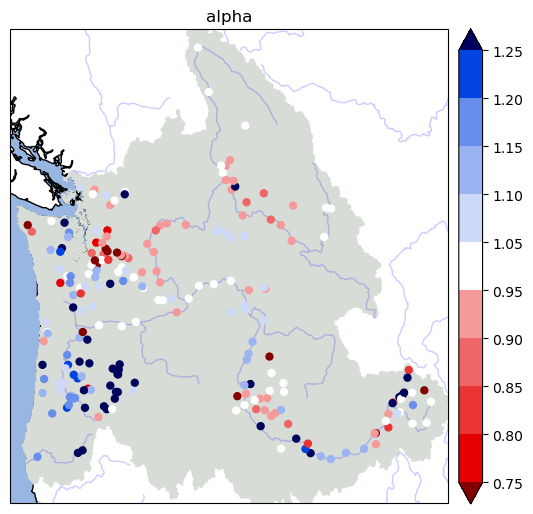

In [35]:
case = 'GMET' # e.g.,'GMET'

df_metric= pd.DataFrame(data=alpha_array, index=common_site, columns=sim_case)
df_metric.reset_index(level=0, inplace=True)
df_metric.rename(columns={'index':'location_name'},inplace=True)
df_metric_final = df_site_selected.merge(df_metric, on="location_name", how = 'inner')

fig, ax1 = plt.subplots(1, figsize=(5.5, 6), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=100)
plt.subplots_adjust(left=0.015, bottom=0.015, right=0.975, top=0.975)

base_map(ax1,df_huc12)
df_metric_final.plot(ax=ax1, column=case, markersize=25, 
                     cmap=color.cmap2, norm=color.norm2, zorder=2, legend=True, 
                     legend_kwds={'extend':'both', 'pad':0.02, 'shrink': 0.825});
ax1.set_title('alpha')

fig.savefig(os.path.join(figure_path, f'Fig4_alpha_{case}.png'), dpi=200)

print(df_metric_final[case].describe())

df_metric_final[case] = (df_metric_final[case]-1)*100
for percent in np.arange(100):
    if np.count_nonzero(np.abs(df_metric_final[case].values)<percent)/np.count_nonzero(~np.isnan(df_metric_final[case].values))>0.80:
        print("%d%% or less bias at 75%% of sites"%percent)
        break

#### 4.3.3 corr

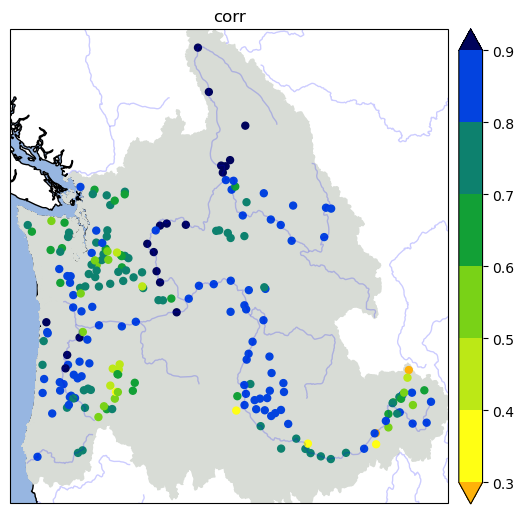

In [36]:
case = 'GMET' # e.g.,'GMET'

df_metric= pd.DataFrame(data=corr_array, index=common_site, columns=sim_case)
df_metric.reset_index(level=0, inplace=True)
df_metric.rename(columns={'index':'location_name'},inplace=True)
df_metric_final = df_site_selected.merge(df_metric, on="location_name", how = 'inner')

fig, ax1 = plt.subplots(1, figsize=(5.5, 6), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=100)
plt.subplots_adjust(left=0.015, bottom=0.015, right=0.975, top=0.975)

base_map(ax1,df_huc12)
df_metric_final.plot(ax=ax1, column=case, markersize=25, 
                     cmap=color.cmap3, norm=color.norm3, legend=True, 
                     legend_kwds={'extend':'both', 'pad':0.02, 'shrink': 0.825});
ax1.set_title('corr')

fig.savefig(os.path.join(figure_path, f'Fig5_corr_{case}.png'), dpi=200)

#### 4.3.4 KGE

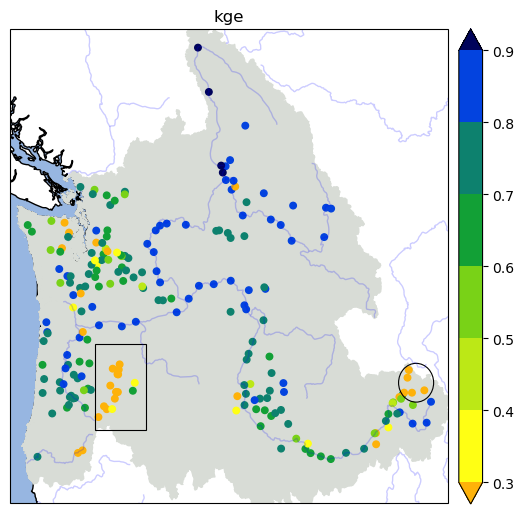

In [37]:
case = 'GMET' # e.g.,'GMET'

df_metric= pd.DataFrame(data=kge_array, index=common_site, columns=sim_case)
df_metric.reset_index(level=0, inplace=True)
df_metric.rename(columns={'index':'location_name'},inplace=True)
df_metric_final = df_site_selected.merge(df_metric, on="location_name", how = 'inner')

fig, ax1 = plt.subplots(1, figsize=(5.5, 6), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=100)
plt.subplots_adjust(left=0.015, bottom=0.015, right=0.975, top=0.975)

base_map(ax1,df_huc12)
df_metric_final.plot(ax=ax1, column=case, markersize=22, cmap=color.cmap3, norm=color.norm3, legend=True, 
                     legend_kwds={'extend':'both', 'pad':0.02, 'shrink': 0.825});
ax1.set_extent([-125, -110, 41.5, 52.5])
ax1.set_title('kge')

ax1.add_patch(mpl.patches.Rectangle((-122.1, 43.2), 1.75, 2,
                                 edgecolor='k',facecolor='None',lw=0.8));
ax1.add_patch(mpl.patches.Ellipse((-111.1, 44.3), 1.2, 0.9,
                                 edgecolor='k',facecolor='None',lw=0.8));

fig.savefig(os.path.join(figure_path, f'Fig6_kge_{case}.png'), dpi=200)

#### 4.3.5 FDC %bias

count    215.000000
mean      21.171879
std       95.084796
min      -44.587462
25%      -14.304606
50%        1.544817
75%       22.151971
max      981.031307
Name: GMET, dtype: float64
33% or less bias at 75% of sites


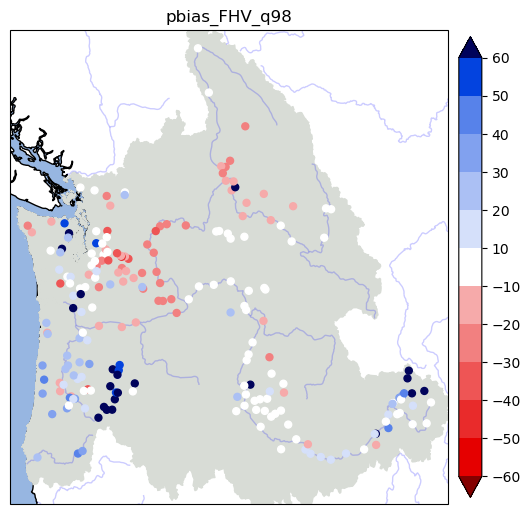

In [38]:
case = 'GMET' # e.g.,'GMET'

df_pbiasFHV = pd.DataFrame(data=pbiasFHV98_array, index=common_site, columns=sim_case)
df_pbiasFHV.reset_index(level=0, inplace=True)
df_pbiasFHV.rename(columns={'index':'location_name'},inplace=True)
df_pbiasFHV_final = df_site_selected.merge(df_pbiasFHV, on="location_name", how = 'inner')

fig = plt.figure(figsize=(5.5, 6), dpi=100)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.015, bottom=0.015, right=0.975, top=0.975)

base_map(ax1,df_huc12)
df_pbiasFHV_final.plot(ax=ax1, column=case, markersize=25, 
                       cmap=color.cmap_bias1, norm=color.norm_bias1, legend=True, zorder=2, 
                       legend_kwds={'extend':'both', 'pad':0.02, 'shrink': 0.800, 
                                    'ticks': [-60, -50, -40, -30, -20, -10, 10, 20, 30, 40, 50, 60]});
ax1.set_title('pbias_FHV_q98')

fig.savefig(os.path.join(figure_path, f'Fig7_pbiasFHV_{case}.png'), dpi=200)

print(df_pbiasFHV_final[case].describe())

for percent in np.arange(100):
    if np.count_nonzero(np.abs(df_pbiasFHV_final[case].values)<percent)/np.count_nonzero(~np.isnan(df_pbiasFHV_final[case].values))>0.80:
        print("%d%% or less bias at 75%% of sites"%percent)
        break

#### 4.3.6 all maps together

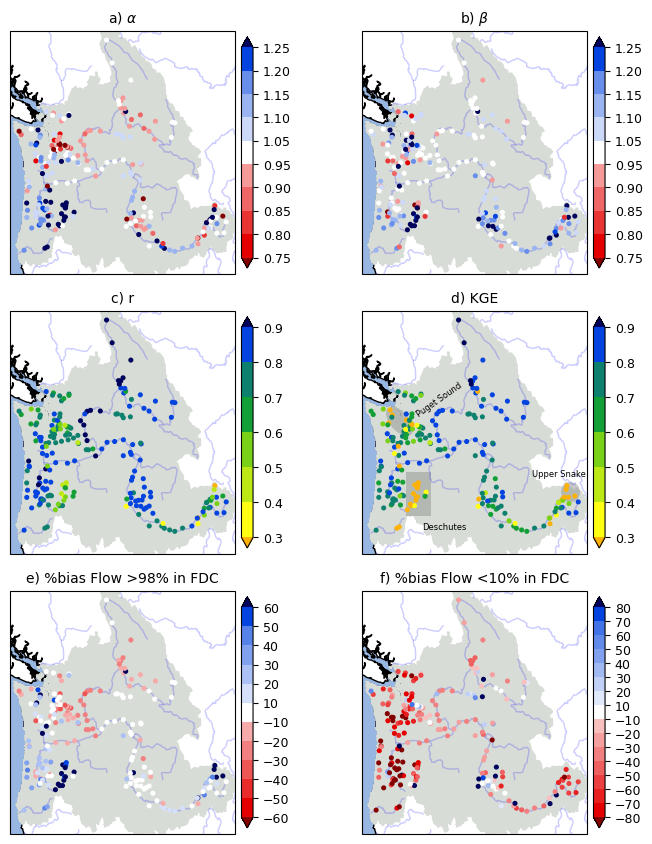

In [39]:
case = 'GMET' # e.g.,'GMET'

fig, ax = plt.subplots(3, 2, figsize=(7.0, 8.5), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=100)
plt.subplots_adjust(left=0.015, bottom=0.015, right=0.975, top=0.96, hspace=0.15, wspace=0.1)

array_collection = {
    'alpha': {'array':alpha_array, 'cmap':color.cmap2, 'norm':color.norm2, 'header':r'a) $\alpha$'},
    'beta': {'array':beta_array, 'cmap':color.cmap2, 'norm':color.norm2, 'header':r'b) $\beta$'},
    'corr': {'array':corr_array, 'cmap':color.cmap3, 'norm':color.norm3, 'header':'c) r'},
    'kge': {'array':kge_array, 'cmap':color.cmap3, 'norm':color.norm3, 'header':'d) KGE'},
    'pbias_FHV': {'array':pbiasFHV98_array, 'cmap':color.cmap_bias1, 'norm':color.norm_bias1, 'header':'e) %bias Flow >98% in FDC'},
    'pbias_FLV': {'array':pbiasFLV10_array, 'cmap':color.cmap_bias2, 'norm':color.norm_bias2, 'header':'f) %bias Flow <10% in FDC'},
}

for ix, (metric, meta) in enumerate(array_collection.items()):
    row = ix // 2
    col = ix % 2
    
    df_metric = pd.DataFrame(data=meta['array'], index=common_site, columns=sim_case)
    df_metric.reset_index(level=0, inplace=True)
    df_metric.rename(columns={'index':'location_name'},inplace=True)
    df_metric_final = df_site_selected.merge(df_metric, on="location_name", how = 'inner')

    base_map(ax[row, col],df_huc12)
    
    if metric == 'pbias_FHV':
        legend_kwds = {'extend':'both', 'pad':0.02, 'shrink': 0.95,
                       'ticks': [-60, -50, -40, -30, -20, -10, 10, 20, 30, 40, 50, 60]}
    elif metric == 'pbias_FLV':
        legend_kwds = {'extend':'both', 'pad':0.02, 'shrink': 0.95,
                       'ticks': list(np.delete(np.arange(-80,90, 10),8))}
    else:
        legend_kwds = {'extend':'both', 'pad':0.02, 'shrink': 0.95,}        
    
    df_metric_final.plot(ax=ax[row, col], column=case, markersize=7, 
                   cmap=meta['cmap'], norm=meta['norm'], legend=True, zorder=2, 
                   legend_kwds=legend_kwds);
    
    if ix==3:
        ax[row, col].add_patch(mpl.patches.Ellipse((-122.5, 47.5), 2.0, 1.0, angle=-30,
                                          edgecolor='None',facecolor='xkcd:grey',lw=0.7, alpha=0.5)); # Eastern Cascade
        ax[row, col].text(-121.5, 47.7, 'Puget Sound', rotation=35, fontsize=6)                                                             
        #ax[row, col].add_patch(mpl.patches.Rectangle((-117.5, 42.2), 7.25, 2.9,
        #                                 edgecolor='k',facecolor='None',lw=0.7)); # Snake
        ax[row, col].add_patch(mpl.patches.Ellipse((-111.1, 44.3), 1.27, 0.9,
                                         edgecolor='None',facecolor='xkcd:grey',lw=0.7, alpha=0.5));# Upper Snake
        ax[row, col].text(-113.7, 45, 'Upper Snake', fontsize=6)
        ax[row, col].add_patch(mpl.patches.Rectangle((-122.1, 43.2), 1.7, 2.0,
                                            edgecolor='None',facecolor='xkcd:grey',lw=0.7, alpha=0.5)); # Deschutes
        ax[row, col].text(-121.0, 42.6, 'Deschutes', fontsize=6)
    
    ax[row, col].set_title(meta['header'], fontsize=10)
    cbar = ax[row, col].get_figure().axes[-1]  # Access the colorbar axis (usually the last axis)
    cbar.tick_params(labelsize=9)   # Set colorbar tick label font siz

for jx in range(ix+1,3*2):
    row = jx // 2
    col = jx % 2
    fig.delaxes(ax[row][col])
    
fig.savefig(os.path.join(figure_path,f'Fig8_metrics_collection_{case}.png'), dpi=300)

## 5. Seasonal flow plots

In [41]:
# Compute flow statistics based on daily data (VIC, SUMMA, NRNI)    
djf_mean_array = np.zeros((num_site, len(all_case)))
mam_mean_array = np.zeros((num_site, len(all_case)))
jja_mean_array = np.zeros((num_site, len(all_case)))
son_mean_array = np.zeros((num_site, len(all_case)))

diff_djf_array = np.zeros((num_site, len(sim_case)))
diff_mam_array = np.zeros((num_site, len(sim_case)))
diff_jja_array = np.zeros((num_site, len(sim_case)))
diff_son_array = np.zeros((num_site, len(sim_case)))

for c, case in enumerate(all_case): 
    if case=='obs':
        season_flow = ds_nrni_selected['streamflow'].groupby('time.season').mean('time')
    else:
        season_flow = ds_sim_selected[case]['streamflow'].groupby('time.season').mean('time')
    for r, site in enumerate(common_site):
        djf_mean_array[r,c] = season_flow.sel(site=site, season='DJF').values
        jja_mean_array[r,c] = season_flow.sel(site=site, season='JJA').values
        mam_mean_array[r,c] = season_flow.sel(site=site, season='MAM').values
        son_mean_array[r,c] = season_flow.sel(site=site, season='SON').values

for c, case in enumerate(sim_case):         
    diff_jja_array[:,c] = jja_mean_array[:,c] - jja_mean_array[:,-1]
    diff_mam_array[:,c] = mam_mean_array[:,c] - mam_mean_array[:,-1]
    diff_djf_array[:,c] = djf_mean_array[:,c] - djf_mean_array[:,-1]
    diff_son_array[:,c] = son_mean_array[:,c] - son_mean_array[:,-1]

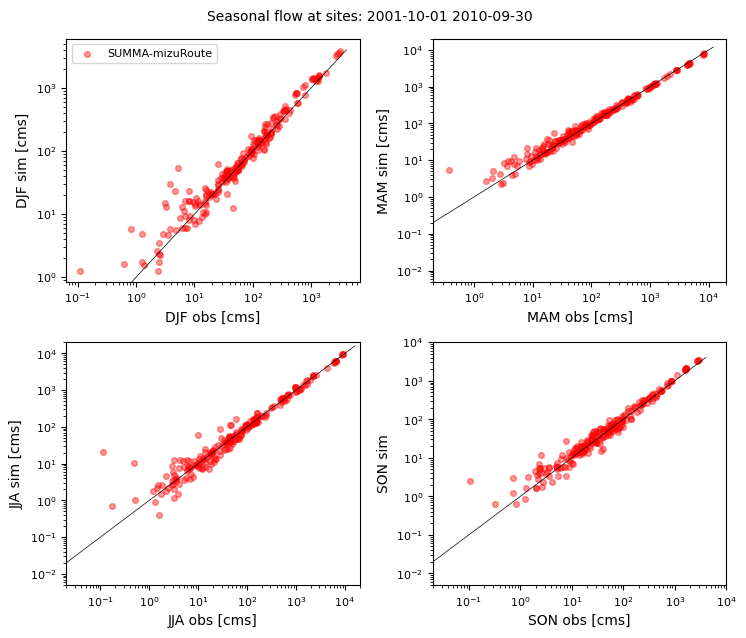

In [42]:
%matplotlib inline 
# 4 panel CDFs (Seasonal mean)
fig = plt.figure(figsize=(7.5, 6.5))
fig.subplots_adjust(left=0.095,right=0.975,bottom=0.095,top=0.935,wspace=0.25,hspace=0.25)

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

ax1.tick_params(labelsize=8)
ax2.tick_params(labelsize=8)
ax3.tick_params(labelsize=8)
ax4.tick_params(labelsize=8)

plot_case = sim_case

#panel a) DJF
for c, case in enumerate(plot_case):
    ax1.scatter(djf_mean_array[:,-1], djf_mean_array[:,c],s=17, c=case_meta[case]['color'], label=case_meta[case]['label'], alpha=0.4)
ax1.plot([0, 4000], [0, 4000], 'black', linewidth=0.5)
lgd = ax1.legend(frameon=True,loc="upper left", handlelength=2, prop={'size':8})
lgd.get_frame().set_facecolor('white')
ax2.set_xlim(2*10**-1, 2*10**4)
ax2.set_ylim(5*10**-3, 2*10**4)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('DJF sim [cms]')
ax1.set_xlabel('DJF obs [cms]')

#panel b) MAM
for c, case in enumerate(plot_case):
    ax2.scatter(mam_mean_array[:,-1], mam_mean_array[:,c], s=17, c=case_meta[case]['color'],label=case_meta[case]['label'], alpha=0.4)
ax2.plot([0, 12000], [0, 12000], 'black', linewidth=0.5)
ax2.set_xlim(2*10**-1, 2*10**4)
ax2.set_ylim(5*10**-3, 2*10**4)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel('MAM sim [cms]')
ax2.set_xlabel('MAM obs [cms]')

#panel c) JJA
for c, case in enumerate(plot_case):
    ax3.scatter(jja_mean_array[:,-1], jja_mean_array[:,c], s=17, c=case_meta[case]['color'], label=case_meta[case]['label'], alpha=0.4)
ax3.plot([0, 16000], [0, 16000], 'black', linewidth=0.5)
ax3.set_xlim(2*10**-2, 2*10**4)
ax3.set_ylim(5*10**-3, 2*10**4)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylabel('JJA sim [cms]')
ax3.set_xlabel('JJA obs [cms]')

#panel d) SON
for c, case in enumerate(plot_case):
    ax4.scatter(son_mean_array[:,-1],son_mean_array[:,c], s=17, c=case_meta[case]['color'],label=case_meta[case]['label'], alpha=0.4)
ax4.plot([0, 4000], [0, 4000], 'black', linewidth=0.5)
ax4.set_xlim(2*10**-2, 1*10**4)
ax4.set_ylim(5*10**-3, 1*10**4)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_ylabel('SON sim')
ax4.set_xlabel('SON obs [cms]');

fig.suptitle('Seasonal flow at sites: %s %s'%(analysis_period.start, analysis_period.stop), fontsize='medium');
plt.savefig(os.path.join(figure_path, 'Fig9_seasonal_flow_scatter.png'), format='png', dpi=200)

## 6. Time series plot 

### 6.2. summary flow plots

Using matplotlib backend: inline


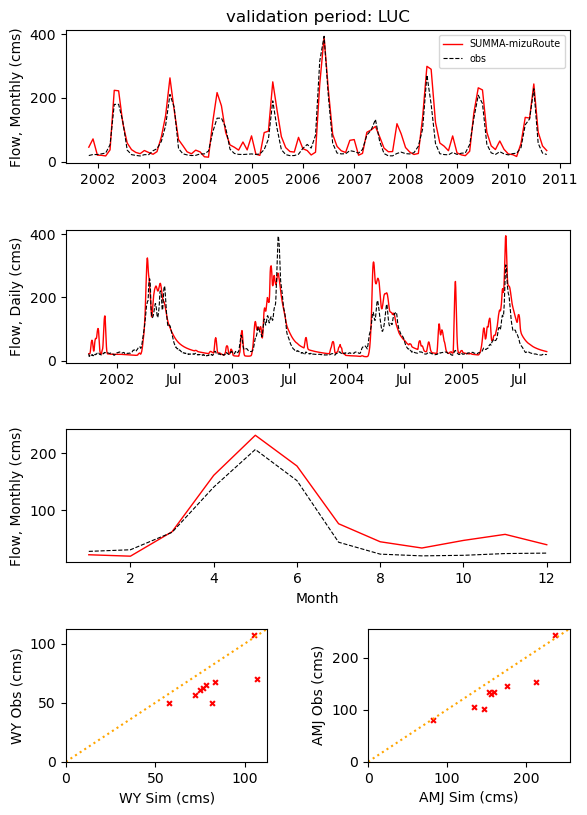

In [48]:
%matplotlib auto

def is_aj(month):
    return (month >= 4) & (month <= 7)

# ---- setup for summary plot
period_name = 'validation'
# cal period plot -> slice('1997-10-01', '2001-09-30') for both
# val period plot -> slice('2001-10-01', '2005-09-30') for daily, and  slice('2001-10-01', '2010-09-30') for month
if period_name == 'calibration':
    daily_period = slice('1997-10-01', '2001-09-30')   
    month_period = slice('1991-10-01', '2001-09-30')
elif period_name == 'validation':
    daily_period = slice('2001-10-01', '2005-09-30')   
    month_period = slice('2001-10-01', '2010-09-30')

obj_plot = ['GMET']

head_title = f'{period_name} period'

# --- loop through sites
for idx, data in df_site_selected.iterrows():
    site = data['location_name']
    # get daily flow 
    ds_sim_daily ={}
    for case in obj_plot:
        ds_sim_daily[case] = ds_sim[case].sel(site=site)['streamflow'].sel(time=daily_period)
    ds_obs_daily = ds_nrni_selected.sel(site=site)['streamflow'].sel(time=daily_period)
    
    # get monthly flow 
    ds_sim_month ={}
    for case in obj_plot:
        ds_sim_month[case] = ds_sim[case].sel(site=site)['streamflow'].sel(time=month_period).resample(time='1ME').mean()
    ds_obs_month = ds_nrni_selected.sel(site=site)['streamflow'].sel(time=month_period).resample(time='1ME').mean()

    # get monthly climatological flow
    ds_sim_month_clim ={}
    ds_sim_month_cal_clim ={}
    for case in obj_plot:
        ds_sim_month_clim[case]     = ds_sim[case].sel(site=site)['streamflow'].sel(time=month_period).groupby('time.month').mean('time')
        ds_sim_month_cal_clim[case] = ds_sim[case].sel(site=site)['streamflow'].sel(time=cal_period).groupby('time.month').mean('time')
    ds_obs_month_clim = ds_nrni_selected.sel(site=site)['streamflow'].sel(time=month_period).groupby('time.month').mean('time')
    ds_obs_month_cal_clim = ds_nrni_selected.sel(site=site)['streamflow'].sel(time=cal_period).groupby('time.month').mean('time')
    
    ds_sim_ann_wy ={}
    for case in obj_plot:
        ds_sim_ann_wy[case] = ds_sim[case].sel(site=site)['streamflow'].sel(time=month_period).resample(time='YS-OCT').mean()
    ds_obs_ann_wy = ds_nrni_selected.sel(site=site)['streamflow'].sel(time=month_period).resample(time='YS-OCT').mean()

    ds_sim_AJ_wy ={}
    for case in obj_plot:
        ds_sim_AJ_wy[case] = ds_sim_month[case].sel(time=is_aj(ds_sim_month[case]['time.month'])).resample(time='YS-OCT').mean()
    ds_obs_AJ_wy = ds_obs_month.sel(time=is_aj(ds_obs_month['time.month'])).resample(time='YS-OCT').mean()

    # ----- creating figure
    fig = plt.figure(figsize=(6.5, 9.5))

    AX = mpl.gridspec.GridSpec(4,2)
    AX.update(wspace = 0.5, hspace = 0.5)
    ax1  = plt.subplot(AX[0,:])
    ax2 = plt.subplot(AX[1,:])
    ax3 = plt.subplot(AX[2,:])
    ax4 = plt.subplot(AX[3,0])
    ax5 = plt.subplot(AX[3,1])

    # plot monthly
    for case in obj_plot:
        ds_sim_month[case].plot(ax=ax1, c=case_meta[case]['color'], linewidth=1.0, label=case_meta[case]['label'])
    ds_obs_month.plot(ax=ax1, color='k', linestyle='dashed', linewidth=0.8, label='obs')
    #ax1.axvspan(pd.to_datetime(cal_period.start), pd.to_datetime(cal_period.stop), alpha=0.2, color='gray')  # this is shading period between two datetime
    
    # plot daily calibration period
    for case in obj_plot:
        ds_sim_daily[case].rolling(time=7, center=True).mean().plot(ax=ax2, c=case_meta[case]['color'], linewidth=1.0, label=None, add_legend=False)
    ds_obs_daily.rolling(time=7, center=True).mean().plot(ax=ax2, color='k', linestyle='dashed', linewidth=0.8, add_legend=False)
    #ax2.axvspan(pd.to_datetime(cal_period.start), pd.to_datetime(cal_period.stop), alpha=0.2, color='gray') # this is shading period between two datetime

    # plot monthly long term averages for period
    for case in obj_plot:
        ds_sim_month_clim[case].plot(ax=ax3, c=case_meta[case]['color'], linewidth=1.0, label=None, add_legend=False)
        #ds_sim_month_cal_clim[case].plot(ax=ax3, c=meta[case]['color'], linewidth=1.5, linestyle='solid', label=None, add_legend=False) 
    ds_obs_month_clim.plot(ax=ax3, color='k', linestyle='dashed', linewidth=0.8, add_legend=False)

    # plot scatter for water year mean flow
    axmax1 = np.max(ds_obs_ann_wy.values)
    ax4.scatter(-10,-10, s=12, c='k', marker='x', label='entire')
    ax4.scatter(-10,-10, s=10, c='k', marker='o', label='calib')
    for case in obj_plot:
        axmax1= np.max([axmax1, np.max(ds_sim_ann_wy[case].values)])
        ax4.scatter(ds_sim_ann_wy[case].values, ds_obs_ann_wy.values, s=12, c=case_meta[case]['color'], marker='x', alpha=1.0)
        ax4.scatter(ds_sim_ann_wy[case].sel(time=cal_period).values, ds_obs_ann_wy.sel(time=cal_period).values, 
                    s=10, c=case_meta[case]['color'])
    ax4.plot((0, axmax1*1.05), (0, axmax1*1.05), c='orange', linestyle=':', label=None)
#    ax4.annotate('corr: '+str(round(corr_WY[0], 3)), xy=(axmax*0.97, axmax*0.10), horizontalalignment='right')

    # plot scatter for spring runoff period (Apr-Jul)
    axmax = np.max(ds_obs_AJ_wy.values)
    for case in obj_plot:
        axmax= np.max([axmax, np.max(ds_sim_AJ_wy[case].values)])
        ax5.scatter(ds_sim_AJ_wy[case].values, ds_obs_AJ_wy.values, s=12, c=case_meta[case]['color'], marker='x', alpha=1.0)
        ax5.scatter(ds_sim_AJ_wy[case].sel(time=cal_period).values, ds_obs_AJ_wy.sel(time=cal_period).values, s=10, c=case_meta[case]['color'])
    ax5.plot((0, axmax*1.05), (0, axmax*1.05), c='orange', linestyle=':', label=None)
#    ax5.annotate('corr: '+str(round(corr_AJ[0], 3)), xy=(axmax*0.97, axmax*0.10), horizontalalignment='right')

    # other plot details
    ax1.set_xlabel('')
    ax1.set_ylabel('Flow, Monthly (cms)')
    ax2.set_title('')
    ax2.set_xlabel('')
    ax2.set_ylabel('Flow, Daily (cms)')
    ax3.set_title('',fontsize="small")
    ax3.set_ylabel('Flow, Monthly (cms)')
    ax3.set_xlabel('Month')
    ax4.set_ylabel('WY Obs (cms)')
    ax4.set_xlabel('WY Sim (cms)')
    if ~np.isnan(axmax1):
        ax4.set_xlim([0, axmax1*1.05])
        ax4.set_ylim([0, axmax1*1.05])
    if ~np.isnan(axmax):
        ax5.set_xlim([0, axmax*1.05])
        ax5.set_ylim([0, axmax*1.05])
    ax5.set_ylabel('AMJ Obs (cms)')
    ax5.set_xlabel('AMJ Sim (cms)')
    ax1.legend(loc='best', fontsize="x-small")
    #ax4.legend(loc='best', fontsize="small")
    #ax2.legend().remove()
    ax1.set_title(head_title + ': ' +site, fontsize=12)
    plotFname=os.path.join(os.path.join(figure_path, 'per_site', f'NB1_fig11_summary_hydrograph_{period_name}_{site}.png'))
    plt.savefig(plotFname, dpi=200, bbox_inches='tight')
    break